In [2]:
import cupy
import numpy as np
from matplotlib import pyplot as plt
import os
from FastMediumWell import gcf

# auto reload 
%load_ext autoreload
%autoreload 2

In [41]:
datanpz = np.load('data/uvw_stokesI.npz')

# uvw = uvw, scan=scan, flag_I=flag_I, stokes_I=stokes_I
uvw = datanpz['uvw']
scan = datanpz['scan']
flag_I = datanpz['flag_I']
stokes_I = datanpz['stokes_I']



In [42]:


src = 'src/funcGridding.cu'

dir_src = os.path.dirname(os.path.realpath(src))

griddingFuncSrc = open(src, 'rt')

griddingSimple = cupy.RawModule(code=griddingFuncSrc.read(), backend='nvcc',options=("-I "+dir_src,))
griddingFun = griddingSimple.get_function("SimpleGridding")

testMem = griddingSimple.get_function("testMem")

In [121]:
process_idx = 1

# how many scan
scan_unique = np.unique(scan)
#for this_scan in scan_unique:
#    ind = np.where(scan == this_scan)[0]
    #plt.plot(uvw[0,ind], uvw[1,ind], 'o')
ind = np.where(scan == process_idx)[0]

uvw_this_scan = uvw[:,ind]
stokes_I_this_scan = stokes_I[ind]

u_inp = uvw_this_scan[0,:]
v_inp = uvw_this_scan[1,:]

I_real = stokes_I_this_scan.real
I_imag = stokes_I_this_scan.imag

image_size = 256

cell =  150 # asec

nx = np.int32(2*image_size)
n_offset = np.int32((nx-image_size)/2)
arc2rad = np.float32(np.pi / 180. / 3600.)

umax = np.max(np.abs(u_inp))
vmax = np.max(np.abs(v_inp))

du = np.float32(1. / (arc2rad * cell)) / (image_size * 2.)

n_umax = np.int32(np.ceil(umax / du))
n_vmax = np.int32(np.ceil(vmax / du))

In [122]:
vmax

505.6758234544237

In [123]:
gcount = u_inp.shape[0]

/tmp/ipykernel_3394593/292761261.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(convGridFuncTab)), 'o')


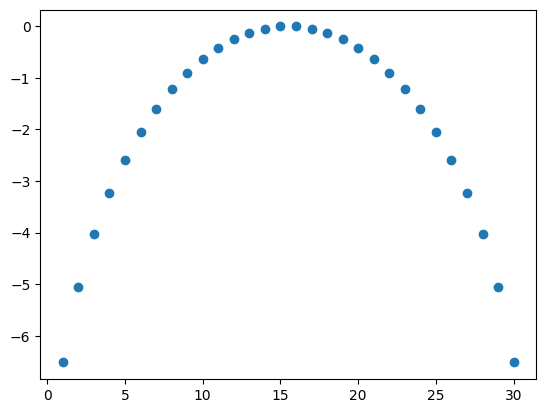

In [124]:
from FastMediumWell import gcf

WIDTH= 6
NCGF= 32
HWIDTH= 3
convGridFuncTab = gcf(NCGF, WIDTH)
plt.plot(np.log(np.abs(convGridFuncTab)), 'o')



# Schwab 1984

In [132]:
blocksize_2D = (8, 16, 1)
gridsize_2D = (np.int32(np.ceil(1. * nx / blocksize_2D[0])),1)
batch_size = np.int32(np.ceil(1. * nx / blocksize_2D[1]))

d_grd = cupy.zeros((np.int32(nx), np.int32(nx)), np.complex64)
d_ngrd = cupy.zeros_like(d_grd)
d_bm = cupy.zeros_like(d_grd)
d_nbm = cupy.zeros_like(d_grd)
d_cbm = cupy.zeros_like(d_grd)

d_u = cupy.asarray(u_inp, dtype=cupy.float32)
d_v = cupy.asarray(v_inp, dtype=cupy.float32)
d_re = cupy.asarray(I_real, dtype=cupy.float32)
d_im = cupy.asarray(I_imag, dtype=cupy.float32)
d_cnt = cupy.zeros_like(d_grd, dtype=cupy.int32)

d_gcf = cupy.asarray(convGridFuncTab, dtype=cupy.float32)

In [133]:
du = cupy.float32(du)

In [134]:

blocksize_2D

(8, 16, 1)

In [135]:
for n in range(1000):
    griddingFun(gridsize_2D, blocksize_2D,
               (d_grd,d_bm, d_cbm, d_cnt, d_u, d_v, d_re, d_im,
                d_gcf, WIDTH,  HWIDTH, NCGF, nx, du, gcount, n_umax, n_vmax, batch_size))
# synchronize
cupy.cuda.Device().synchronize()

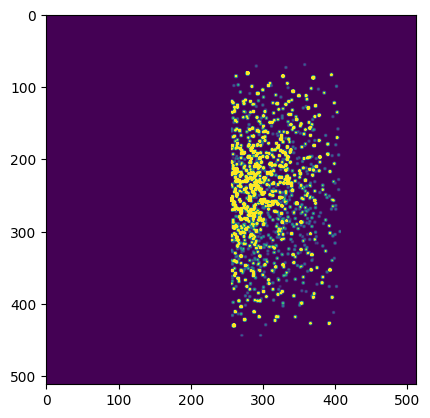

In [140]:
plt.imshow((np.abs(d_grd.get())),vmax=30e6)


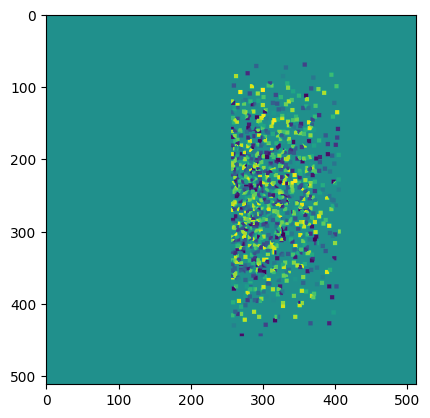

In [137]:
plt.imshow((np.angle(d_grd.get())))

In [111]:

my_arr = cupy.array([1,1],dtype=cupy.int32)


testMem((8,1,1), (4,4),(my_arr,))

a = 1.100000
a = 1.100000
a = 1.100000
a = 1.100000


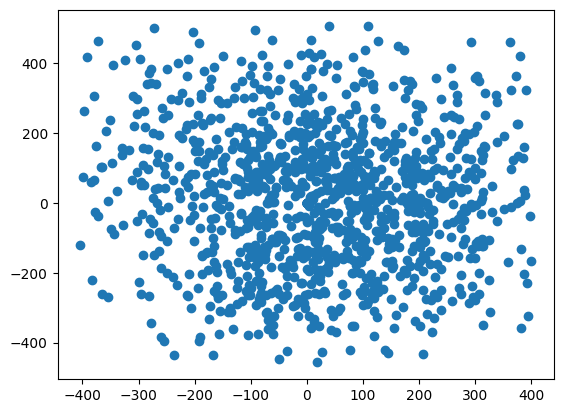

In [35]:
plt.plot(u_inp, v_inp, 'o')

In [38]:
u_inp.shape

(1176,)